# Image Classification with Malaria Dataset
 This is a malaria dataset which contains approximately 27,500 cell images of parasitized and uninfected cells from thin blood smear slide images of segmented cells.

 Using this dataset, we would like you to create a model which is able to classify whether a blood smear is **uninfected** or **parasitized**.

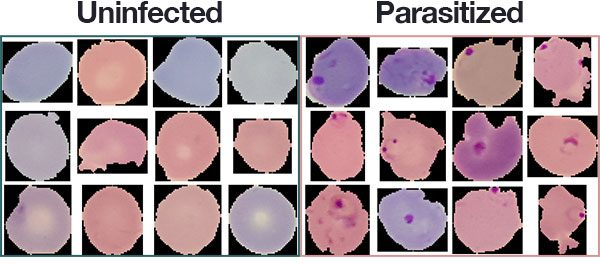

## Overview

1. Data Loadding and Preprocessing
2. Exploratory Data Analysis
3. Model Development and Training
4. Model Evaluation and Deployment


## Importing the necessary Libraries

In [2]:
print(tf.__version__)

2.15.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Activation, Dropout, BatchNormalization, AveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import scipy


sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
%pwd

'/content'

In [3]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [4]:
home = "/content/drive/MyDrive/Malaria_data/"

In [3]:
# Loading the dataset
data, info = tfds.load('malaria', split='train', shuffle_files=True, batch_size = 64, with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteIP3FA2/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [7]:
print("Number of classes: " + str(info.features['label'].num_classes))
print("Class names: " + str(info.features['label'].names))

Number of classes: 2
Class names: ['parasitized', 'uninfected']


In [8]:
len(data)

431

## Exploratory Data Analysis

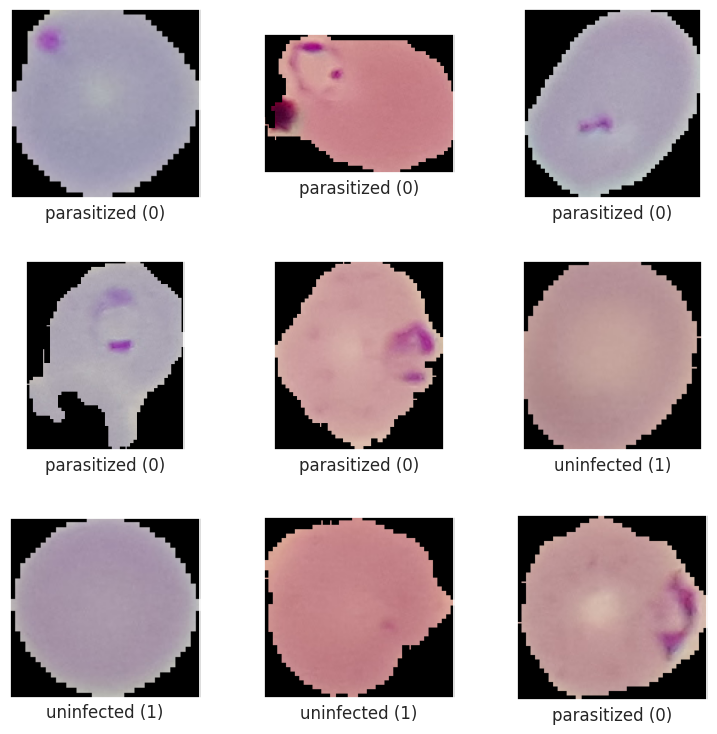

In [12]:
# Visualizing a sample of the dataset

fig = tfds.show_examples(data, info)

From the above visualization we can see that the images have different sizes

## Feature Extraction

In [9]:
# #Converting the images into numpy arrays for further analysis

# train_images = []
# train_labels = []

# for sample in data:
#     train_images.append(sample['image'].numpy())
#     train_labels.append(sample['label'].numpy())

In [10]:
# train_images = np.array(train_images)
# train_labels = np.array(train_labels)

## Model Development

In [5]:
# Initialize constants

IMG_SIZE = (224, 224)
BATCH_SIZE = 64

tf.random.set_seed(42)

In [6]:
#Performing cross_validation to prevent overfitting i.e. train-70%, val-20%, test-10%

train_dataset, val_dataset, test_dataset = tfds.load('malaria',
                                      split=['train[:70%]', 'train[70%:90%]', 'train[90%:]'],
                                      shuffle_files=True, as_supervised=True)

In [12]:
print("Num of training images: ", len(train_dataset))
print("Num of validation images: ",len(val_dataset))
print("Num of testing images: ",len(test_dataset))

Num of training images:  19291
Num of validation images:  5511
Num of testing images:  2756


In [16]:
# The images have different sizes therefor we need to normalize them

for image, label in train_dataset.take(1): # taking one sample image
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (145, 148, 3)
Label:  1


In [8]:
# Transformations

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # tf.cast(image, tf.float32) / 255., label

    #convert to floating point
    image = tf.image.convert_image_dtype(image, tf.float32)

    #resize to 256 by 256 with is the standard size used by most models
    image = tf.image.resize_with_crop_or_pad(image, 224, 224)

    return image, label

In [9]:
#Applying the method to our datasets

train_set = (
    train_dataset
    .cache()
    .map(normalize_img)
    .batch(BATCH_SIZE)
)

val_set = (
    val_dataset
    .cache()
    .map(normalize_img)
    .batch(BATCH_SIZE)
)

test_dataset = (
    test_dataset
    .cache()
    .map(normalize_img)
    .batch(BATCH_SIZE)
)

In [13]:
# Visualize

image_batch, label_batch = next(iter(train_set))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n] == 1:
            plt.title("uninfected")
        else:
            plt.title("parasitized")
        plt.axis("off")

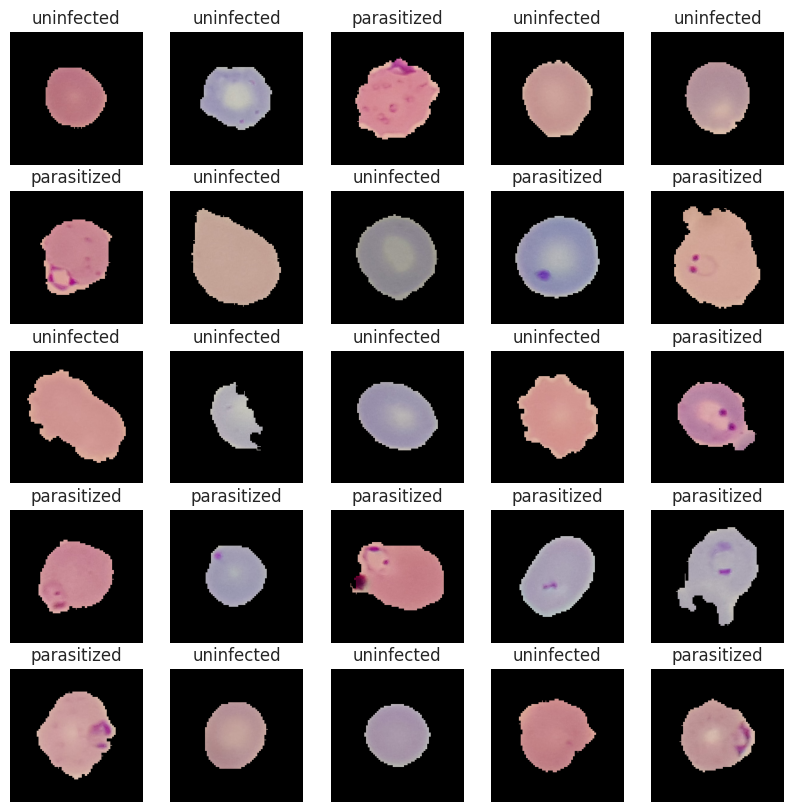

In [14]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Model Architecture

In [15]:
#NOTE: The images have been resized to 256 by 256, the batch_size is 64

def Mymodel():
    model = Sequential([
        #1st CNN layer: in_channels = 3(rgb), out_channels = 64 feature maps of width n height(224x224)
        Conv2D(64, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        #Purpose of using pool layer is to half the size of the input i.e 64x222x222 to 64x111x111
        AveragePooling2D(2,2),

        #2nd CNN layer
        Conv2D(64, (3,3), activation='relu'),
        AveragePooling2D(2,2),  #64 x 55 x 55

        #3rd CNN layer
        Conv2D(64, (3,3), activation='relu'),
        AveragePooling2D(2,2),

        #4th CNN layer
        Conv2D(64, (3,3), activation='relu'),
        AveragePooling2D(2,2),

        #5th CNN layer
        Conv2D(64, (3,3), activation='relu'),
        AveragePooling2D(2,2),

        #6th CNN layer
        Conv2D(64, (3,3), activation='relu'),
        AveragePooling2D(2,2),

        Flatten(),

        Dense(64, activation='relu'),
        Dropout(p=0.5),
        Dense(32, activation='relu'),
        Dropout(p=0.5),
        #Only 1 output neuron. It will contain a value from 0-1 where  1 class (uninfected) and 0 class (infected)
        Dense(1, activation='sigmoid')
    ])

    return model



In [16]:
model_1 = Mymodel()

In [55]:
model_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 average_pooling2d_32 (Aver  (None, 111, 111, 64)      0         
 agePooling2D)                                                   
                                                                 
 conv2d_33 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 average_pooling2d_33 (Aver  (None, 54, 54, 64)        0         
 agePooling2D)                                                   
                                                                 
 conv2d_34 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 average_pooling2d_34 (Aver  (None, 26, 26, 64)       

In [17]:
# Model hyperparameter configuration
model_1.compile(
    optimizer='adam',
    loss='binary_crossentropy', # since its  binary classification,
    metrics = ['accuracy'] # measures how many classifications the model predicted right.
    )

In [18]:
home

'/content/drive/MyDrive/Malaria_data/'

In [24]:
# NOTE: A callback is a set of functions to be applied at given stages of the training procedure.
#You can use callbacks to get a view on internal states and statistics of the model during training.

# creating path to save model

checkpoint_path = home + "model1cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
                                                  filepath=checkpoint_path,
                                                  save_weights_only=True, #only save the model weights
                                                  verbose=1,
                                                  epochs = 20,
                                                  save_freq=3)

# Early stopping- when there is a stall in model learning , the process should come to a halt; loss is the metric being monitored
early_stop_cp = tf.keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)


## Training of the Model

In [25]:
print("Training process initialized!!")

history = model_1.fit(
                      train_set,
                      validation_data= val_set,
                      epochs=20,
                      callbacks=[cp_callback, early_stop_cp]
)

Training process initialized!!
Epoch 1/20
  2/302 [..............................] - ETA: 35s - loss: 0.1191 - accuracy: 0.9688
Epoch 1: saving model to /content/drive/MyDrive/Malaria_data/model1cp.ckpt
  5/302 [..............................] - ETA: 42s - loss: 0.1353 - accuracy: 0.9625
Epoch 1: saving model to /content/drive/MyDrive/Malaria_data/model1cp.ckpt
  8/302 [..............................] - ETA: 41s - loss: 0.1176 - accuracy: 0.9668
Epoch 1: saving model to /content/drive/MyDrive/Malaria_data/model1cp.ckpt
 11/302 [>.............................] - ETA: 40s - loss: 0.1140 - accuracy: 0.9688
Epoch 1: saving model to /content/drive/MyDrive/Malaria_data/model1cp.ckpt
 14/302 [>.............................] - ETA: 40s - loss: 0.1256 - accuracy: 0.9654
Epoch 1: saving model to /content/drive/MyDrive/Malaria_data/model1cp.ckpt
 17/302 [>.............................] - ETA: 39s - loss: 0.1274 - accuracy: 0.9632
Epoch 1: saving model to /content/drive/MyDrive/Malaria_data/model1

The model has an accuracy of 96% and validation loss of 0.1 which is quite good.


## Model Evaluation

In [37]:
model_1.evaluate(test_dataset)

44/44 [==============================] - 2s 50ms/step - loss: 0.1329 - accuracy: 0.9586


[0.1329001486301422, 0.958635687828064]

In [38]:
#save model

model_1.save(home + "model1.h5")

From the above results we can see that our model performs very well with an accuracy of 96%.
However, there is still room for improvement through experimentation with hyperparameters and also use of transfer learning with a custom classifier

## Loading Saved Model

In [11]:
loaded_model = tf.keras.models.load_model(home + "model1.h5")
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 average_pooling2d (Average  (None, 111, 111, 64)      0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 average_pooling2d_1 (Avera  (None, 54, 54, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 average_pooling2d_2 (Avera  (None, 26, 26, 64)        0

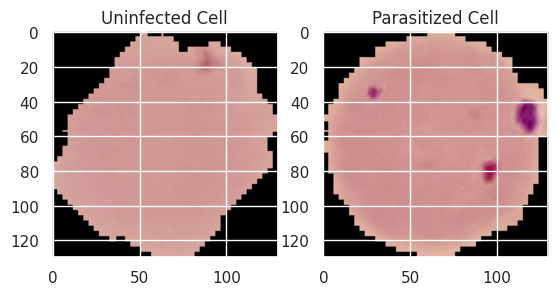

In [21]:
# testing some images
infected_cell = "/content/parasitized.png"
uninfected_cell = "/content/uninfected.png"

_, ax = plt.subplots(1, 2)
ax[0].imshow(plt.imread(uninfected_cell))
ax[0].title.set_text("Uninfected Cell")
ax[1].imshow(plt.imread(infected_cell))
ax[1].title.set_text("Parasitized Cell")
plt.show()

In [27]:
model_input_shape = loaded_model.input_shape
print(f"Model input shape: {model_input_shape}")

Model input shape: (None, 224, 224, 3)


In [34]:
# function to predict on unseen image
def predict(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x,axis=0)
    proba = loaded_model.predict(x)[0][0]
    y = "Uninfected" if proba > 0.5 else "Parasitized"
    return y, proba

1/1 [==============================] - 0s 349ms/step


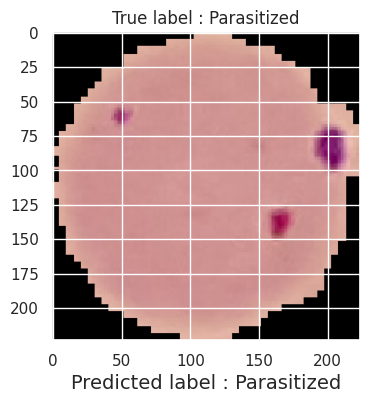

In [39]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
import os

# prediction on parasitized image
# img = "/content/parasitized.png"

img = load_img("/content/parasitized.png", target_size=(224, 224))

plt.figure(figsize=(4,4))
plt.title("True label : Parasitized")
y, proba = predict(img) # Prediction
plt.xlabel(f"Predicted label : {y}", fontsize=14)
plt.imshow(img)

## Using Transfer Learning

In [44]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.vgg19 import VGG19

In [47]:
#Initializing the pre-trained model Vgg
Img_SIZE = [224, 224]
pretrain_model = VGG19(input_shape= Img_SIZE + [3], weights='imagenet', include_top=False)

In [48]:
pretrain_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [49]:
# Freezing in order to avoid training already existing weights
for layer in pretrain_model.layers:
    layer.trainable = False

In [50]:
# flattening the last output of vgg
x = Flatten()(pretrain_model.output)

In [52]:
from tensorflow.keras.models import Model

#last layer- Adding custom classifier specific to our problem

# classifier = Dense(2, activation='softmax')(x)
classifier = Dense(2, activation='sigmoid')(x)

# create a model object
model = Model(inputs= pretrain_model.input, outputs=classifier)

In [53]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [55]:

# metrics = ['accuracy',
#            metrics.Precision(name='precision'),
#            metrics.Recall(name='recall')
#           ]

# model.compile(
#   loss='binary_crossentropy',
#   optimizer='adam',
#   metrics=metrics
# )

In [56]:
# history = model.fit_generator(train_set, steps_per_epoch = total_train // BATCH_SIZE,
#                        epochs = 35,
#                        validation_data = validation_generator,
#                        validation_steps = total_val // batch_size)